# MLND Capstone Project
---
### Mushroom Identification
**AUTHOR:** Raymond Holsapple  
**DATE:** January 2018

---

## 0. Python Environment Setup

In [1]:
# Import standard data analysis modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from IPython.display import display
import seaborn as sns

# Change color cycle for plotting
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['c', 'm', 'g', 'r', 'b', 'y', 'k'])

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import classifiers
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

# Import various classification tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

# Import evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import matthews_corrcoef

Using TensorFlow backend.


---

## 1. Data Preprocessing

In [3]:
# Load the data. This variable will  not be modified, so that I may always access the data in its original form.
original_data = pd.read_csv('mushrooms.csv')

# Make a copy of the data to replace the `?` (missing data) with `n` (none) in the `stalk-root` attribute.
data = original_data.copy()
data['stalk-root'].replace(to_replace='?', value='n', inplace=True)

# Create the `label` series, and then map `p` to 1 and `e` to 0.
label_raw = data['class']
label = label_raw.map({'p': 1, 'e': 0})

# Create the `features` dataframe, and one-hot encode the values. 
# This increases the number of features from 22 to 117.
features_raw = data.drop('class', axis=1)
features = pd.get_dummies(features_raw)

---

## 2. Data Exploration

In [4]:
# Look at a basic statistical description of `data`.
data.describe().transpose()

,count,unique,top,freq
class,8124,2,e,4208
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728


### 2.1. Create a data distribution graph

In [5]:
def describe_props(df):
    """
    This function takes a dataframe with categorical data and constructs a dictionary containing 
    the percentages of all the unique values for all of the features (including the label)
    """
    
    props = {}
    for col in df:
        n_data = df[col].count()
        feature_props = {}
        for val in df[col].unique():
            feature_props[val] = int((df[col].value_counts()[val] / n_data) * 10000) / 100
        props[col] = feature_props
        
    return props

In [6]:
# Build the dictionary of categorical proportions for each feature.
prop_data = describe_props(data)

# Print the proportions succinctly. The actual values are rounded to 2 decimal places, 
# but the code below will truncate those values to print them all to the screen nicely.
for key, value in prop_data.items():
    rounded_value = {}
    for rv_key, rv_value in value.items():
        rounded_value[rv_key] = int(rv_value)
    print('{}:'.format(key), rounded_value, '\n')

cap-surface: {'s': 31, 'f': 28, 'y': 39, 'g': 0} 

class: {'e': 51, 'p': 48} 

stalk-color-above-ring: {'c': 0, 'g': 7, 'n': 5, 'p': 23, 'w': 54, 'b': 5, 'e': 1, 'o': 2, 'y': 0} 

gill-spacing: {'c': 83, 'w': 16} 

veil-type: {'p': 100} 

habitat: {'u': 4, 'l': 10, 'g': 26, 'p': 14, 'w': 2, 'd': 38, 'm': 3} 

stalk-root: {'c': 6, 'b': 46, 'n': 30, 'e': 13, 'r': 2} 

stalk-color-below-ring: {'c': 0, 'g': 7, 'n': 6, 'p': 23, 'w': 53, 'b': 5, 'e': 1, 'o': 2, 'y': 0} 

ring-type: {'l': 15, 'f': 0, 'e': 34, 'p': 48, 'n': 0} 

stalk-shape: {'t': 56, 'e': 43} 

cap-color: {'u': 0, 'c': 0, 'n': 28, 'e': 18, 'p': 1, 'w': 12, 'b': 2, 'g': 22, 'r': 0, 'y': 13} 

stalk-surface-below-ring: {'s': 60, 'f': 7, 'y': 3, 'k': 28} 

gill-color: {'h': 9, 'w': 14, 'b': 21, 'r': 0, 'u': 6, 'n': 12, 'e': 1, 'p': 18, 'k': 5, 'y': 1, 'o': 0, 'g': 9} 

population: {'a': 4, 'c': 4, 'n': 4, 's': 15, 'v': 49, 'y': 21} 

veil-color: {'w': 97, 'n': 1, 'o': 1, 'y': 0} 

stalk-surface-above-ring: {'s': 63, 'f': 6, 'k':

In [7]:
def data_prop_subplot(data_dict):
    """
    This function takes in a dictionary of feature value percentages and creates a barchart subplot.
    """
    
    fig, axes = plt.subplots(3, 8, figsize=(20, 8))
    
    axes[0, 0].bar(range(len(data_dict['class'])), list(data_dict['class'].values()), color='orange')
    axes[0, 0].set_title('Label', fontsize=14, fontweight='heavy')
    axes[0, 0].set_ylabel('Percentage', fontsize=20, fontweight='heavy')
    axes[0, 0].set_xticks(range(len(data_dict['class'])))
    axes[0, 0].set_xticklabels(list(data_dict['class'].keys()))
    axes[0, 0].tick_params(labelsize=12)
    
    subplot_counter = 1
    
    for key, value in data_dict.items():
        if key == 'class':
            continue
        row = subplot_counter // 8
        col = subplot_counter % 8
        axes[row, col].bar(range(len(data_dict[key])), list(data_dict[key].values()), color='b')
        axes[row, col].set_title('{}'.format(key), fontsize=14, fontweight='heavy')
        if col == 0:
            axes[row, col].set_ylabel('Percentage', fontsize=20, fontweight='heavy')
        axes[row, col].set_xticks(range(len(data_dict[key])))
        axes[row, col].set_xticklabels(list(data_dict[key].keys()))
        axes[row, col].tick_params(labelsize=12)
        
        subplot_counter += 1
        
    fig.delaxes(axes[2, 7])
    plt.tight_layout()
    plt.savefig('images/feature_distributions.pdf')
    plt.show()
    
    return None

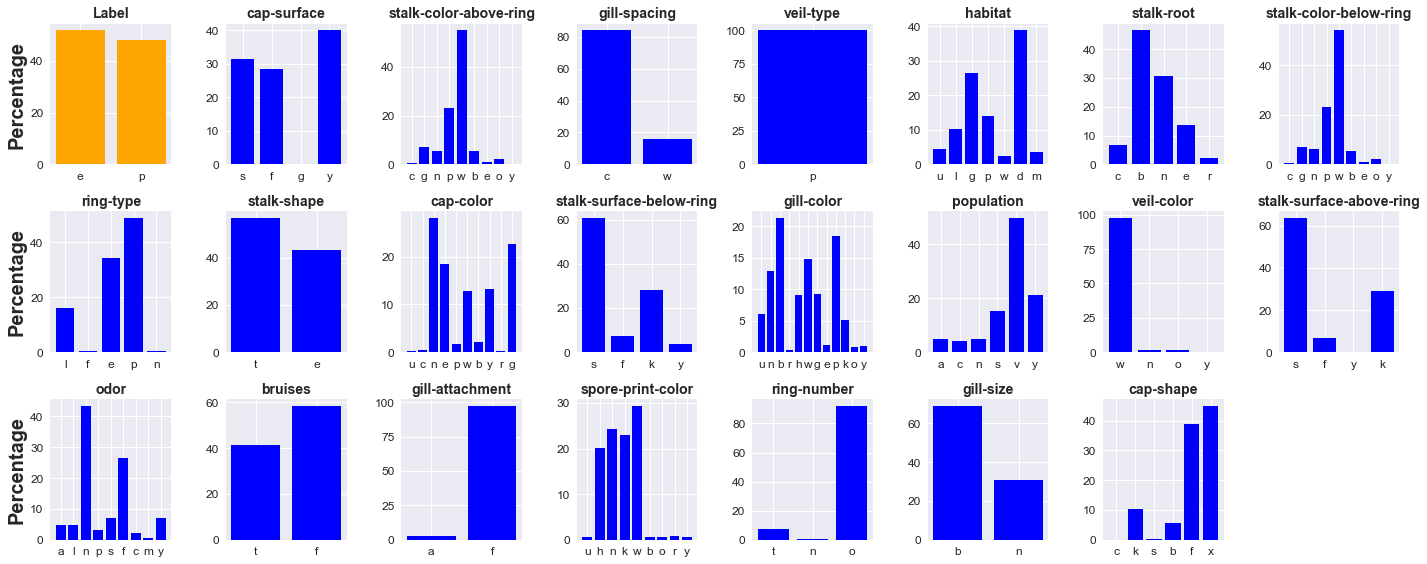

In [8]:
data_prop_subplot(prop_data)

---

## 3. Analysis

### 3.1. Create training and testing data

In [9]:
# Split the data into training and testing subsets. Sometimes I will want to have access to the 
# entire tuple in a succinct way, and sometimes I will want to access individual components of 
# the tuple but make use of a descriptive label inplace of a non-descriptive index, e.g., Xy[2].
Xy = train_test_split(features, label, test_size=0.2, random_state=1984)
X_train, X_test, y_train, y_test = Xy

# I need a global variable to use in the baseline NN function that can be modified inside other functions.
nn_input_dim = X_train.shape[1]

### 3.2. Initialize classifiers

In [10]:
def baseline_nn():
    """
    This function constructs and compiles a baseline NN for initial evaluation.
    It has to be executed before creating a `KerasClassifier()` instance.
    """
    
    global nn_input_dim
    
    # Create model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=nn_input_dim))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# A collection of classifiers to try on the dataset.
clf_1 = LinearSVC(random_state=1984)
clf_2 = KNeighborsClassifier()
clf_3 = SGDClassifier(random_state=1984)
clf_4 = GaussianNB()
clf_5 = AdaBoostClassifier(random_state=1984)
clf_6 = RandomForestClassifier(random_state=1984)
clf_7 = GradientBoostingClassifier(random_state=1984)
clf_8 = KerasClassifier(build_fn=baseline_nn, epochs=10, verbose=0)

# If you want to try all, uncomment the line below and comment the one at the bottom.
# clfs = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6, clf_7]

# Stochastic GD and Gaussian NB are not nearly as good as the others, so I removed them.
clfs = [clf_1, clf_2, clf_5, clf_6, clf_7, clf_8]

### 3.3. Evaluation functions

In [12]:
def get_slice_limits(data_len, n=5):
    """
    n (int): number of uniformly increasing data slice sizes.
    """
    
    props = [int(100 / n)]
    N = {props[0]: int(round(data_len / n))}
    
    for k in range(n - 2):
        props.append(int(props[0] * (k + 2)))
        N[props[k + 1]] = N[props[0]] * (k + 2)
        
    if n > 1:
        props.append(100)
        N[100] = data_len
    
    return props, N

In [13]:
def fpe(clf, Xy, n=100):
    """
    Fit, Predict, Evaluate
    """
    
    global nn_input_dim
    
    X_trn, X_tst, y_trn, y_tst = Xy
    nn_input_dim = X_trn.shape[1]
    evals = {}
    
    if clf.__class__.__name__ == 'KerasClassifier':
        Xy_eval = Xy
        clf.fit(X_trn[:n].values, y_trn[:n])
        predictions = clf.predict(X_tst.values)
    else:
        clf.fit(X_trn[:n], y_trn[:n])
        predictions = clf.predict(X_tst)
        
    evals['accuracy'] = accuracy_score(y_tst, predictions)
    evals['precision'] = precision_score(y_tst, predictions)
    evals['recall'] = recall_score(y_tst, predictions)
    evals['f_2'] = fbeta_score(y_tst, predictions, beta=2)
    
    return evals

In [14]:
def build_eval_data(clfs, Xy, props, N):
    """
    Run `fpe()` for each classifier and training data slice combination, 
    and build the evaluation data structure used for plotting.
    """
    
    eval_data = {}
    
    for clf in clfs:
        clf_name = clf.__class__.__name__
        clf_eval_data = {}
        for prop, n_val in N.items():
            clf_eval_data[prop] = fpe(clf, Xy, n=n_val)
        eval_data[clf_name] = [[clf_eval_data[k]['accuracy']  for k in props],
                               [clf_eval_data[k]['precision'] for k in props],
                               [clf_eval_data[k]['recall']    for k in props],
                               [clf_eval_data[k]['f_2']       for k in props]]
        
    return eval_data

In [15]:
def reduce_feature_space(X, y, n_features):
    """
    This function reduces the number of features using `SelectKBest` from 
    `sklearn.feature_selection`. The scoring function used to select the
    top `n_features` features is `mutual_info_classif`. This scoring function
    computes the mutual information for each feature.
    """
    
    selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
    selector.fit(X, y)
    high_var_support = selector.get_support(indices=True)
    features_reduced = features.iloc[:, high_var_support]
    
    return features_reduced

### 3.4. Visualization functions

In [16]:
def print_eval_data(eval_data):
    """
    Print the final (100% of training data) scores for all classifiers to standard out.
    """
    
    for clf_name, data in eval_data.items():
        name_len = len(clf_name)
        print(clf_name)
        print(name_len*'*')
        print('  -Accuracy Score:  {:7.5f}'.format(data[0][-1]))
        print('  -Precision Score: {:7.5f}'.format(data[1][-1]))
        print('  -Recall Score:    {:7.5f}'.format(data[2][-1]))
        print('  -F_2 Score:       {:7.5f}\n\n'.format(data[3][-1]))

In [17]:
def graph_eval_data(eval_data, props, n_features='all'):
    """
    Visualize the evaluation data.
    """
    
    # Set plot style and create subplot object
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(2, 2, figsize=(13, 10), sharex=True, sharey=True)
    
    # Plot the `accuracy` data
    for clf_name, data in eval_data.items():
        axes[0, 0].plot(props, data[0], 'o-', label=clf_name, markersize=8, linewidth=3)
    axes[0, 0].legend(fontsize=12, loc='best')
    axes[0, 0].set_title('Accuracy on Testing Data', fontsize=30, fontweight='heavy')
    axes[0, 0].set_ylabel('score', fontsize=24, fontweight='heavy')
    axes[0, 0].tick_params(labelsize=16)
    
    # Plot the `precision` data
    for clf_name, data in eval_data.items():
        axes[0, 1].plot(props, data[1], 'o-', label=clf_name, markersize=8, linewidth=3)
    axes[0, 1].legend(fontsize=12, loc='best')
    axes[0, 1].set_title('Precision on Testing Data', fontsize=30, fontweight='heavy')

    # Plot the `recall` data
    for clf_name, data in eval_data.items():
        axes[1, 0].plot(props, data[2], 'o-', label=clf_name, markersize=8, linewidth=3)
    axes[1, 0].legend(fontsize=12, loc='best')
    axes[1, 0].set_title('Recall on Testing Data', fontsize=30, fontweight='heavy')
    axes[1, 0].set_xlabel('proportion of training data used to fit model', fontsize=18, fontweight='heavy')
    axes[1, 0].set_ylabel('score', fontsize=24, fontweight='heavy')
    axes[1, 0].tick_params(labelsize=16)

    # Plot the `F_2` data
    for clf_name, data in eval_data.items():
        axes[1, 1].plot(props, data[3], 'o-', label=clf_name, markersize=8, linewidth=3)
    axes[1, 1].legend(fontsize=12, loc='best')
    axes[1, 1].set_title('$F_2$ Score on Testing Data', fontsize=30, fontweight='heavy')
    axes[1, 1].set_xlabel('proportion of training data used to fit model', fontsize=18, fontweight='heavy')
    axes[1, 1].tick_params(labelsize=16)
    
    plt.xticks(props)
    plt.tight_layout()
    plt.savefig('images/clf_eval_{}.pdf'.format(n_features))
    plt.show()
    
    return None

In [18]:
def mcc_feature_heatmap(df, n_features='all'):
    """
    This function creates and displays a heatmap for the correlations of the features of the input dataframe.
    The correlation used is the Matthews Correlation Coefficient, a.k.a., the Phi Coefficient. The function
    returns the correlation matrix used to create the heatmap.
    
    For further information see: https://en.wikipedia.org/wiki/Phi_coefficient or 
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
    """
    
    N = df.shape[1]
    mcc_matrix = np.zeros((N, N))
    
    for j in range(N):
        mcc_matrix[j, j] = 1.0
        for k in range(j+1, N):
            mcc = matthews_corrcoef(df.iloc[:, j], df.iloc[:, k])
            mcc_matrix[j, k] = mcc
            mcc_matrix[k, j] = mcc
            
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(mcc_matrix, cmap='RdGy', ax=ax, xticklabels=False, yticklabels=False);
    ax.set_title('Matthews Correlation Coefficient Heatmap', fontsize=30, fontweight='heavy')
    ax.set_xlabel('FEATURES', fontsize=24, fontweight='heavy')
    ax.set_ylabel('FEATURES', fontsize=24, fontweight='heavy')
    plt.tight_layout()
    plt.savefig('images/feature_heatmap_{}.pdf'.format(n_features))
    plt.show()
            
    return mcc_matrix

In [19]:
def mcc_label_heatmap(df, df_labels, n_features='all'):
    """
    This function creates and displays a heatmap for the correlations between each feature and the labels
    for the input dataframe. A value of +1 or -1 in this metric would correspond to a feature that is a 
    perfect classifier for the labels. The correlation used is the Matthews Correlation Coefficient, a.k.a., 
    the Phi Coefficient. The function returns the correlation matrix used to create the heatmap.
    
    For further information see: https://en.wikipedia.org/wiki/Phi_coefficient or 
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
    """
    
    N = df.shape[1]
    mcc_row = []
    
    for j in range(N):
        mcc_row.append(matthews_corrcoef(df_labels, df.iloc[:, j]))
        
    mcc_matrix = [mcc_row for k in range(N)]
            
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.heatmap(mcc_matrix, cmap='RdGy', ax=ax, xticklabels=False, yticklabels=False);
    ax.set_title('Matthews Correlation Coefficient Heatmap', fontsize=30, fontweight='heavy')
    ax.set_xlabel('FEATURES', fontsize=24, fontweight='heavy')
    ax.set_ylabel('LABELS', fontsize=24, fontweight='heavy')
    plt.tight_layout()
    plt.savefig('images/label_heatmap_{}.pdf'.format(n_features))
    plt.show()
            
    return mcc_matrix

### 3.5. Evaluation pipeline

In [20]:
def clf_eval_pipe(clfs, Xy, n_subsamps=5, reduce_features=False, n_features=10, print_data=True, graph_data=True):
    """
    A pipeline to perform a baseline comparison of multiple classifier models.
    Output is a subplot figure showing the accuracy, precision, recall, and F_2
    scores for each classifier model over a range of training data subsamples.
        
    User may also perform feature reduction using this pipeline. Simply set 
    `reduce_features=True` and select the number of features using `n_features`.
    If `reduce_features=False`, the parameter `n_features` is ignored.
        
    Note: even though the models are trained on subsets of the training data,
    all metrics are computed using the full testing set, which is not used to
    train the models.
    """
    
    X_trn, X_tst, y_trn, y_tst = Xy
    props, N = get_slice_limits(X_trn.shape[0], n_subsamps)
    
    if not reduce_features:
        eval_data = build_eval_data(clfs, Xy, props, N)
        if print_data:
            print_eval_data(eval_data)
        if graph_data:
            graph_eval_data(eval_data, props)
            mcc_feature_heatmap(features)
            mcc_label_heatmap(features, label)
    else:
        features_reduced = reduce_feature_space(X_trn, y_trn, n_features)
        Xy_reduced = train_test_split(features_reduced, label, test_size=0.2, random_state=1984)
        eval_data_reduced = build_eval_data(clfs, Xy_reduced, props, N)
        if print_data:
            print_eval_data(eval_data_reduced)
        if graph_data:
            graph_eval_data(eval_data_reduced, props, n_features=n_features)
            mcc_feature_heatmap(features_reduced, n_features=n_features)
            mcc_label_heatmap(features_reduced, label, n_features=n_features)
        
        return eval_data_reduced, Xy_reduced
        
    return eval_data

### 3.6. Initial evaluation and classifier comparison (all features)

KerasClassifier
***************
  -Accuracy Score:  1.00000
  -Precision Score: 1.00000
  -Recall Score:    1.00000
  -F_2 Score:       1.00000


AdaBoostClassifier
******************
  -Accuracy Score:  1.00000
  -Precision Score: 1.00000
  -Recall Score:    1.00000
  -F_2 Score:       1.00000


RandomForestClassifier
**********************
  -Accuracy Score:  1.00000
  -Precision Score: 1.00000
  -Recall Score:    1.00000
  -F_2 Score:       1.00000


KNeighborsClassifier
********************
  -Accuracy Score:  1.00000
  -Precision Score: 1.00000
  -Recall Score:    1.00000
  -F_2 Score:       1.00000


GradientBoostingClassifier
**************************
  -Accuracy Score:  0.99877
  -Precision Score: 1.00000
  -Recall Score:    0.99733
  -F_2 Score:       0.99787


LinearSVC
*********
  -Accuracy Score:  1.00000
  -Precision Score: 1.00000
  -Recall Score:    1.00000
  -F_2 Score:       1.00000




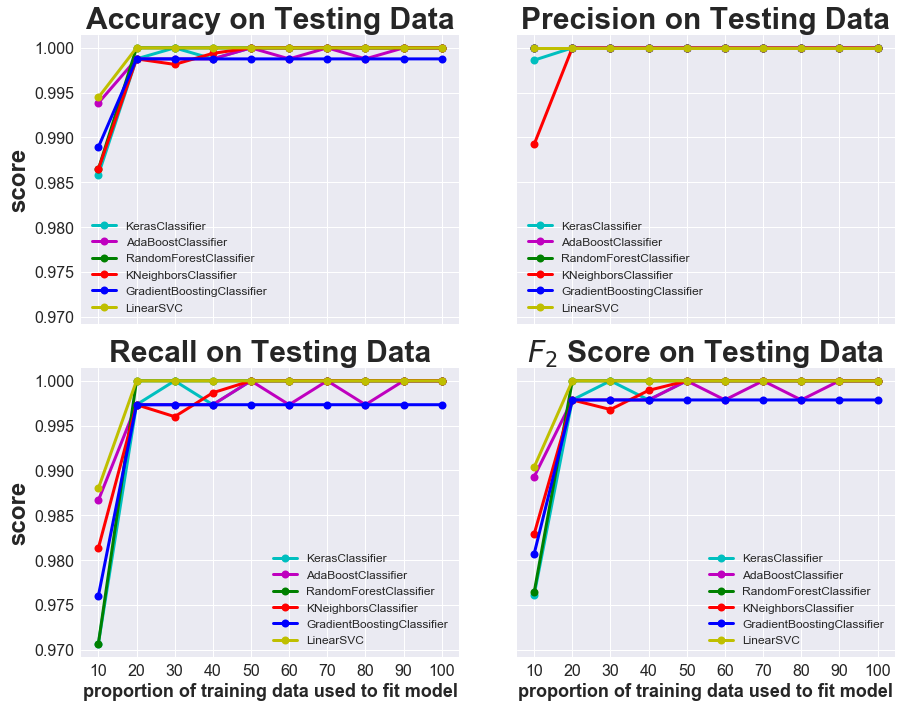

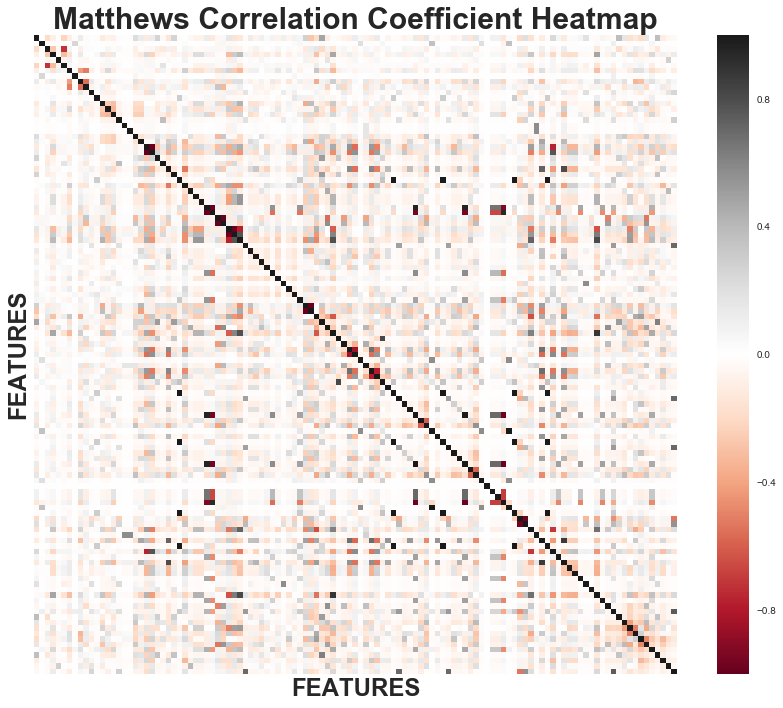

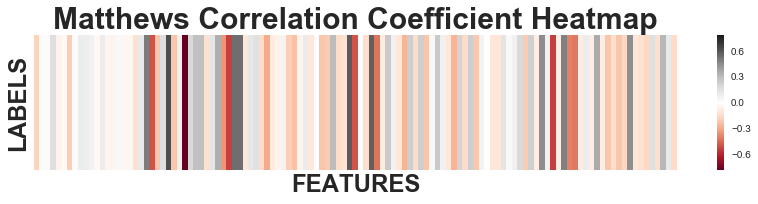

In [21]:
ed = clf_eval_pipe(clfs, Xy, n_subsamps=10, print_data=True, graph_data=True)
# display(ed)

---

## 4. Refinement

### 4.1. Feature selection

#### 4.1.1. Top 15 features

KerasClassifier
***************
  -Accuracy Score:  0.97785
  -Precision Score: 0.97347
  -Recall Score:    0.97867
  -F_2 Score:       0.97762


AdaBoostClassifier
******************
  -Accuracy Score:  0.95631
  -Precision Score: 0.95940
  -Recall Score:    0.94533
  -F_2 Score:       0.94811


RandomForestClassifier
**********************
  -Accuracy Score:  0.97785
  -Precision Score: 0.97347
  -Recall Score:    0.97867
  -F_2 Score:       0.97762


KNeighborsClassifier
********************
  -Accuracy Score:  0.97846
  -Precision Score: 0.97226
  -Recall Score:    0.98133
  -F_2 Score:       0.97950


GradientBoostingClassifier
**************************
  -Accuracy Score:  0.97785
  -Precision Score: 0.97347
  -Recall Score:    0.97867
  -F_2 Score:       0.97762


LinearSVC
*********
  -Accuracy Score:  0.96738
  -Precision Score: 0.95201
  -Recall Score:    0.97867
  -F_2 Score:       0.97322




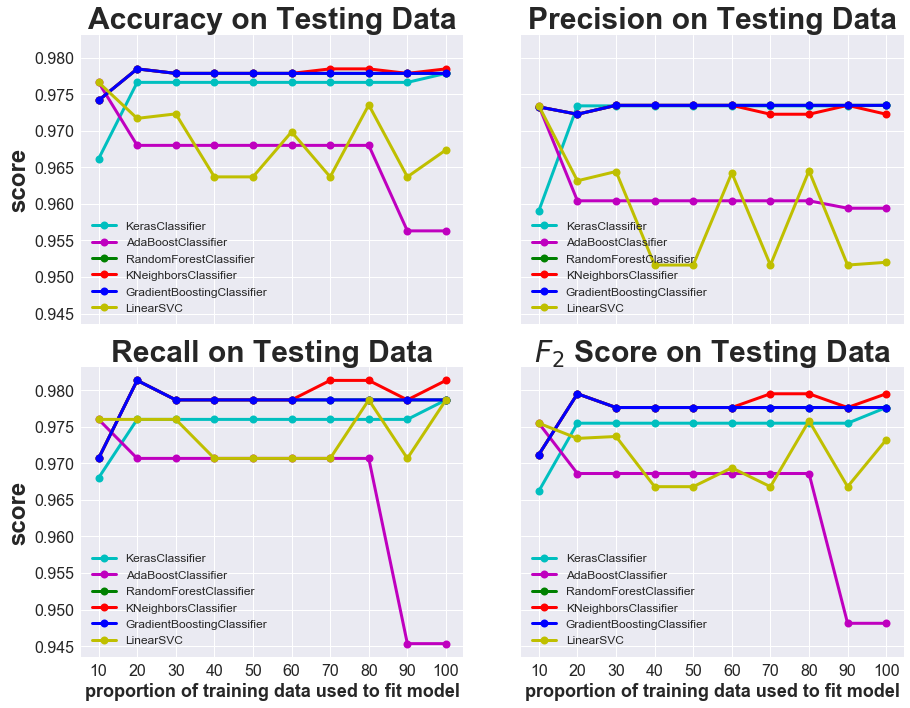

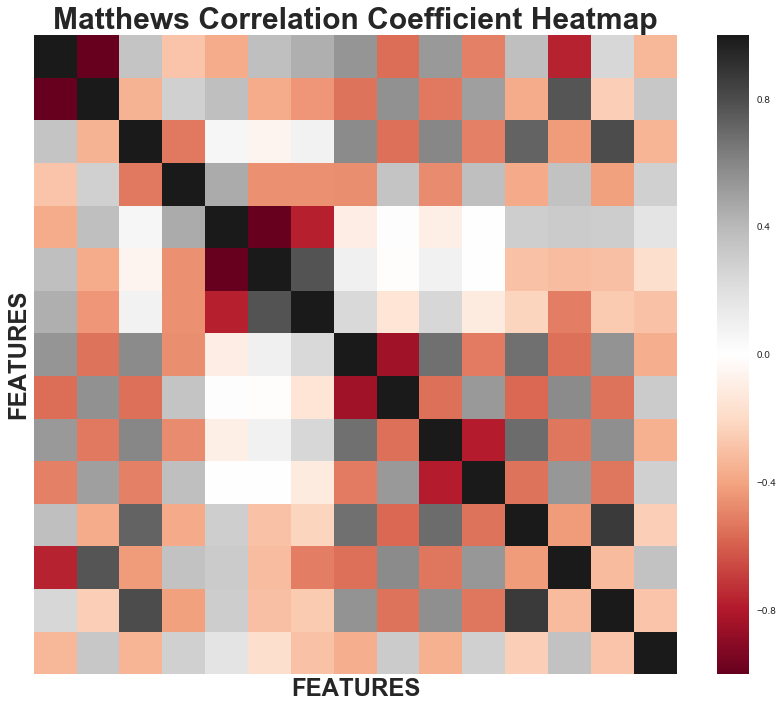

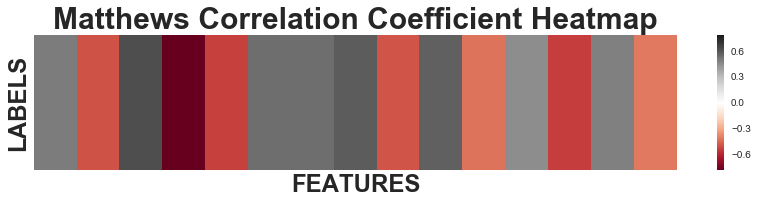

['bruises_f',
 'bruises_t',
 'odor_f',
 'odor_n',
 'gill-size_b',
 'gill-size_n',
 'gill-color_b',
 'stalk-surface-above-ring_k',
 'stalk-surface-above-ring_s',
 'stalk-surface-below-ring_k',
 'stalk-surface-below-ring_s',
 'ring-type_l',
 'ring-type_p',
 'spore-print-color_h',
 'spore-print-color_n']

In [22]:
ed_15, Xy_15 = clf_eval_pipe(clfs, Xy, n_subsamps=10, reduce_features=True, n_features=15)
display(list(Xy_15[0].columns.values))
# display(ed_15)

#### 4.1.2. Top 12 features

KerasClassifier
***************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


AdaBoostClassifier
******************
  -Accuracy Score:  0.97415
  -Precision Score: 0.97326
  -Recall Score:    0.97067
  -F_2 Score:       0.97118


RandomForestClassifier
**********************
  -Accuracy Score:  0.97785
  -Precision Score: 0.97347
  -Recall Score:    0.97867
  -F_2 Score:       0.97762


KNeighborsClassifier
********************
  -Accuracy Score:  0.97662
  -Precision Score: 0.96842
  -Recall Score:    0.98133
  -F_2 Score:       0.97872


GradientBoostingClassifier
**************************
  -Accuracy Score:  0.97785
  -Precision Score: 0.97347
  -Recall Score:    0.97867
  -F_2 Score:       0.97762


LinearSVC
*********
  -Accuracy Score:  0.97354
  -Precision Score: 0.96452
  -Recall Score:    0.97867
  -F_2 Score:       0.97580




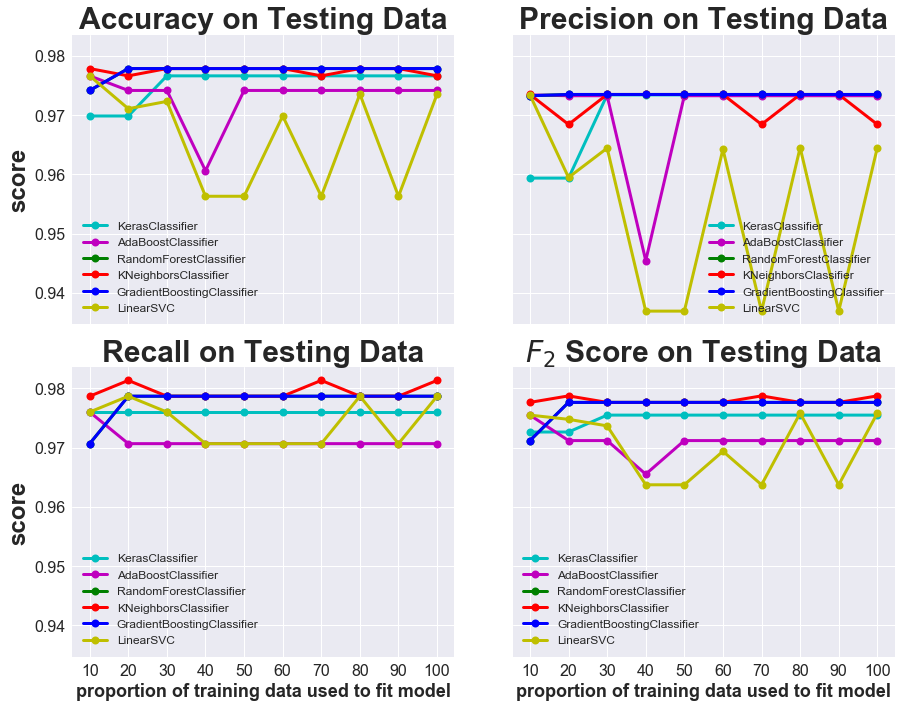

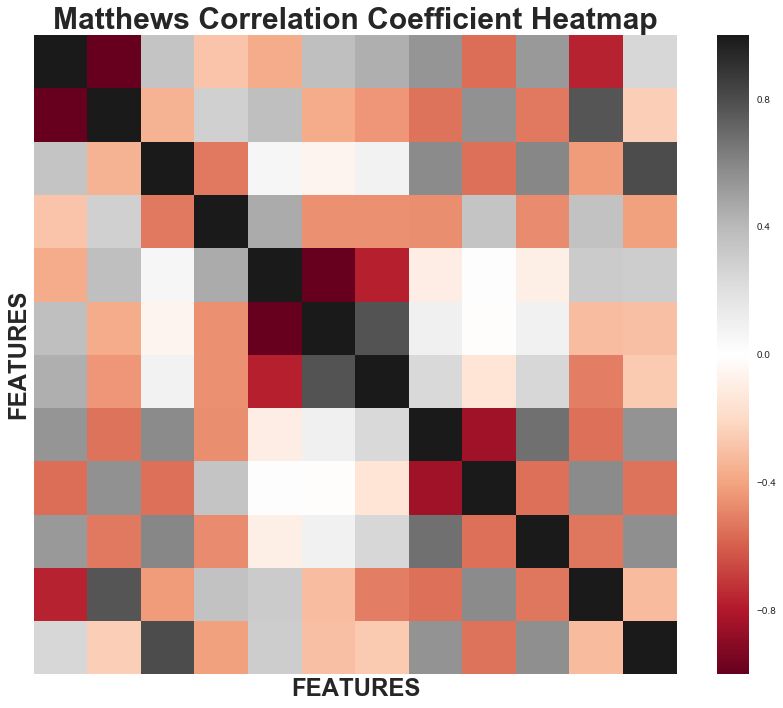

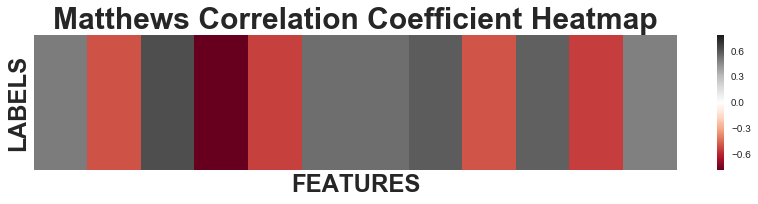

['bruises_f',
 'bruises_t',
 'odor_f',
 'odor_n',
 'gill-size_b',
 'gill-size_n',
 'gill-color_b',
 'stalk-surface-above-ring_k',
 'stalk-surface-above-ring_s',
 'stalk-surface-below-ring_k',
 'ring-type_p',
 'spore-print-color_h']

In [23]:
ed_12, Xy_12 = clf_eval_pipe(clfs, Xy, n_subsamps=10, reduce_features=True, n_features=12)
display(list(Xy_12[0].columns.values))
# display(ed_12)

#### 4.1.3. Top 10 features

KerasClassifier
***************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


AdaBoostClassifier
******************
  -Accuracy Score:  0.96062
  -Precision Score: 0.94545
  -Recall Score:    0.97067
  -F_2 Score:       0.96552


RandomForestClassifier
**********************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


KNeighborsClassifier
********************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


GradientBoostingClassifier
**************************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


LinearSVC
*********
  -Accuracy Score:  0.97108
  -Precision Score: 0.95948
  -Recall Score:    0.97867
  -F_2 Score:       0.97477




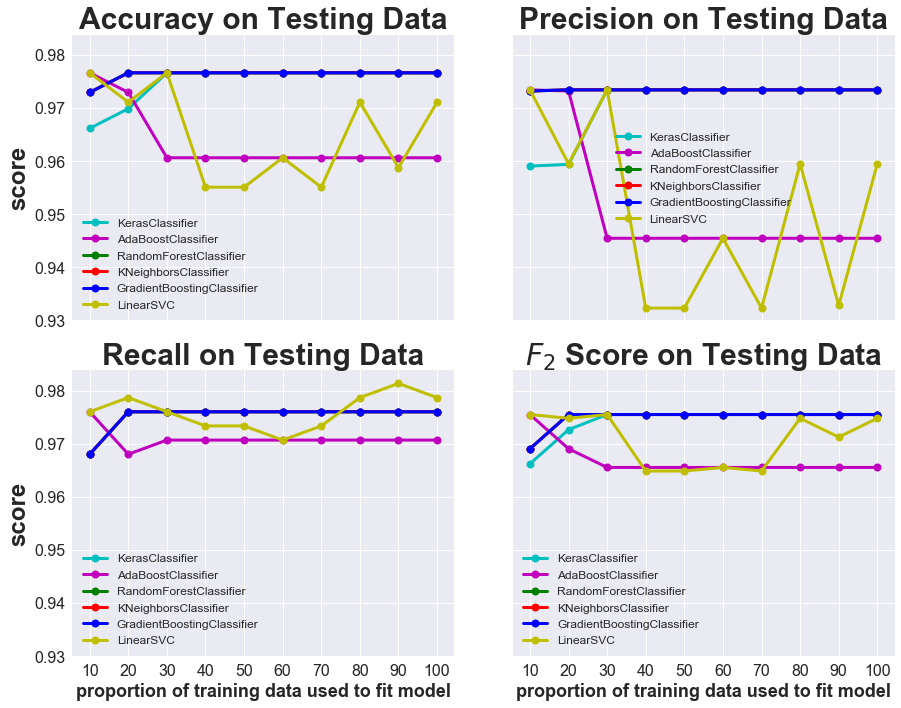

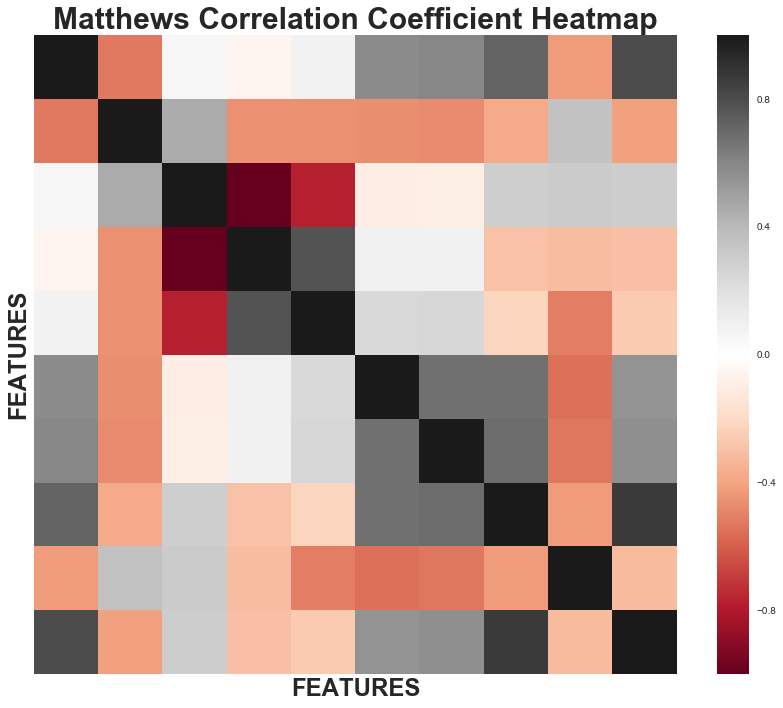

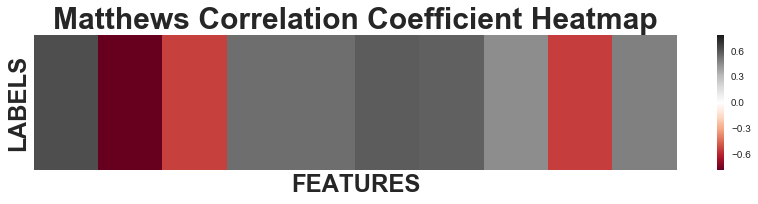

['odor_f',
 'odor_n',
 'gill-size_b',
 'gill-size_n',
 'gill-color_b',
 'stalk-surface-above-ring_k',
 'stalk-surface-below-ring_k',
 'ring-type_l',
 'ring-type_p',
 'spore-print-color_h']

In [24]:
ed_10, Xy_10 = clf_eval_pipe(clfs, Xy, n_subsamps=10, reduce_features=True, n_features=10)
display(list(Xy_10[0].columns.values))
# display(ed_10)

#### 4.1.4. Top 7 features

KerasClassifier
***************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


AdaBoostClassifier
******************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


RandomForestClassifier
**********************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


KNeighborsClassifier
********************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


GradientBoostingClassifier
**************************
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


LinearSVC
*********
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548




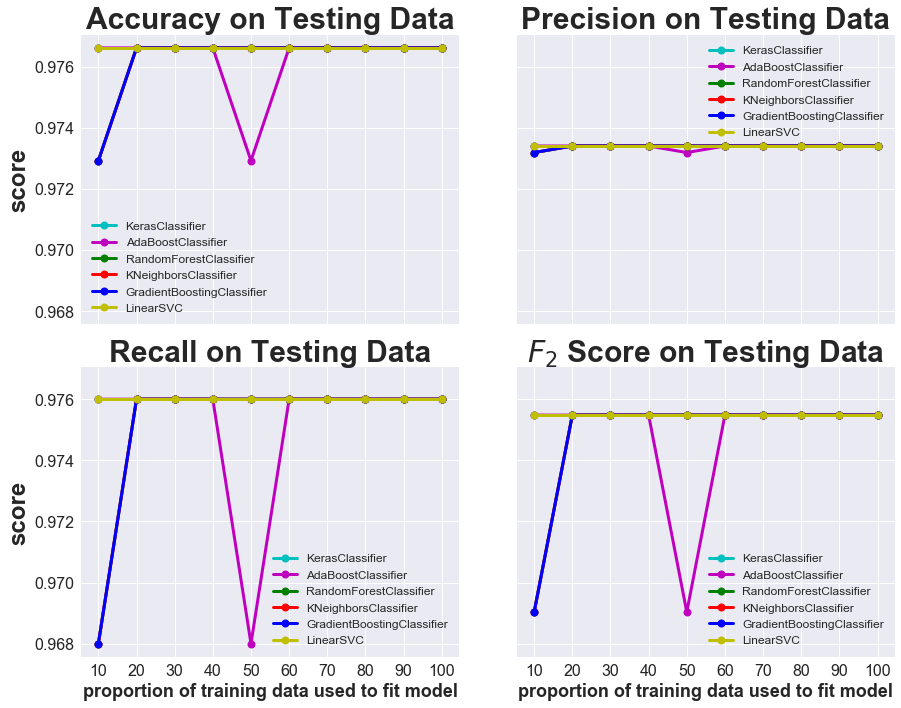

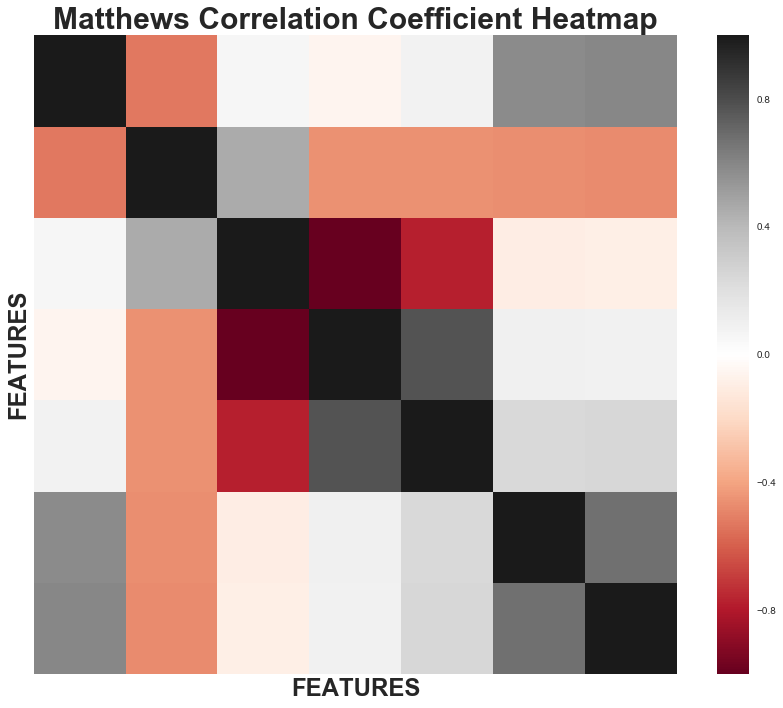

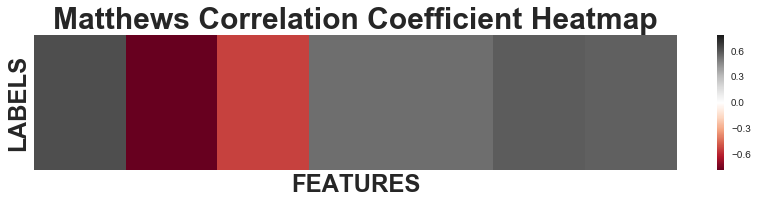

['odor_f',
 'odor_n',
 'gill-size_b',
 'gill-size_n',
 'gill-color_b',
 'stalk-surface-above-ring_k',
 'stalk-surface-below-ring_k']

In [25]:
ed_7, Xy_7 = clf_eval_pipe(clfs, Xy, n_subsamps=10, reduce_features=True, n_features=7)
display(list(Xy_7[0].columns.values))
# display(ed_7)

#### 4.1.5. Top 5 features

KerasClassifier
***************
  -Accuracy Score:  0.92923
  -Precision Score: 1.00000
  -Recall Score:    0.84667
  -F_2 Score:       0.87345


AdaBoostClassifier
******************
  -Accuracy Score:  0.92923
  -Precision Score: 1.00000
  -Recall Score:    0.84667
  -F_2 Score:       0.87345


RandomForestClassifier
**********************
  -Accuracy Score:  0.92923
  -Precision Score: 1.00000
  -Recall Score:    0.84667
  -F_2 Score:       0.87345


KNeighborsClassifier
********************
  -Accuracy Score:  0.88000
  -Precision Score: 0.80936
  -Recall Score:    0.96800
  -F_2 Score:       0.93149


GradientBoostingClassifier
**************************
  -Accuracy Score:  0.92923
  -Precision Score: 1.00000
  -Recall Score:    0.84667
  -F_2 Score:       0.87345


LinearSVC
*********
  -Accuracy Score:  0.92923
  -Precision Score: 1.00000
  -Recall Score:    0.84667
  -F_2 Score:       0.87345




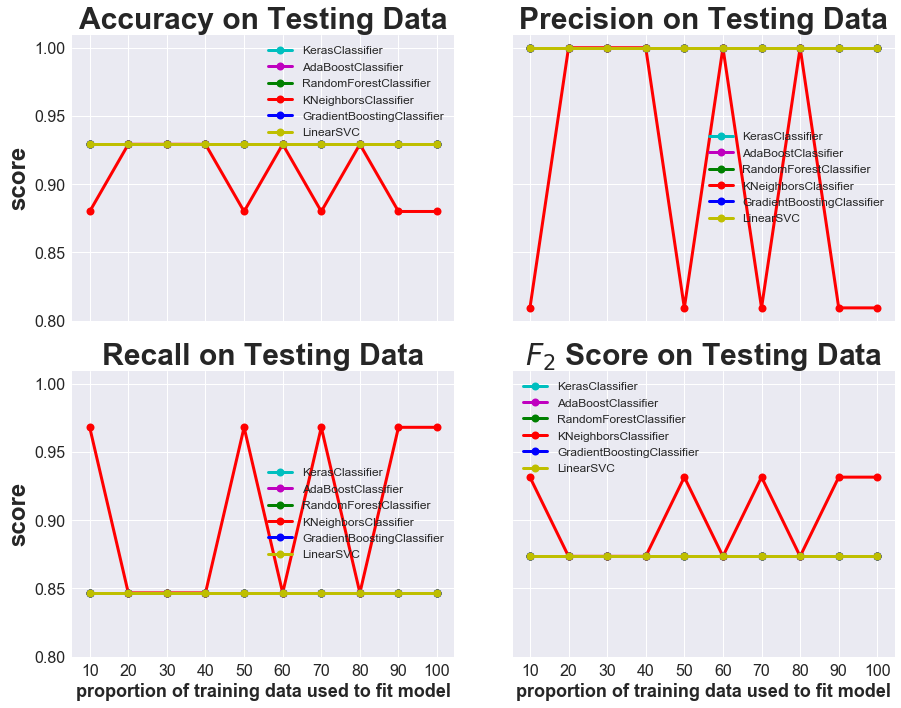

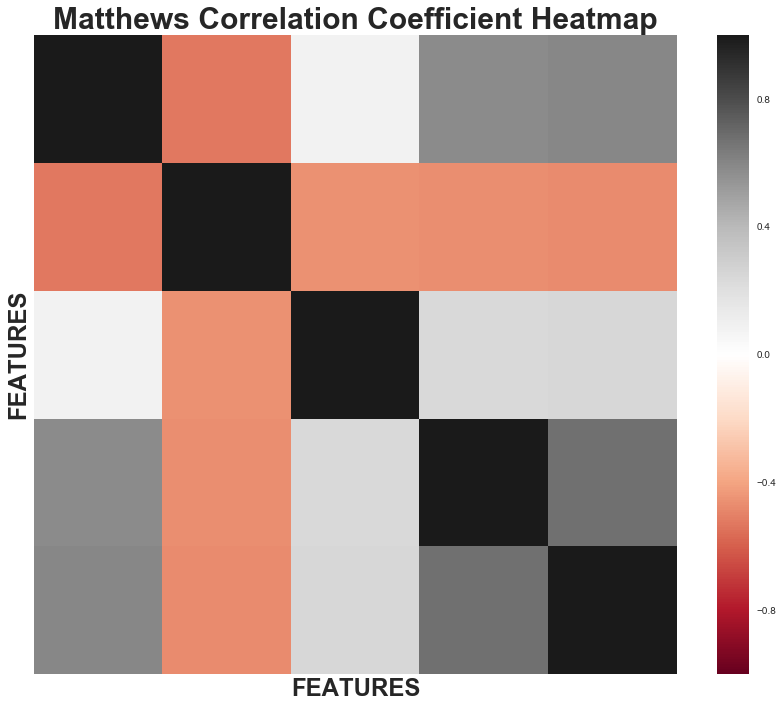

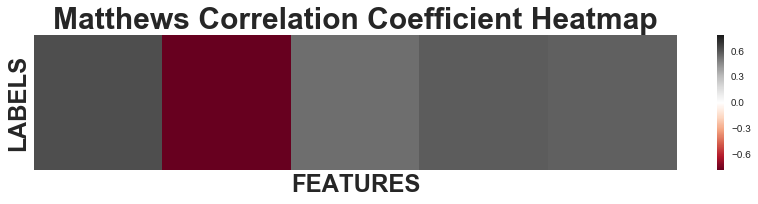

['odor_f',
 'odor_n',
 'gill-color_b',
 'stalk-surface-above-ring_k',
 'stalk-surface-below-ring_k']

In [26]:
ed_5, Xy_5 = clf_eval_pipe(clfs, Xy, n_subsamps=10, reduce_features=True, n_features=5)
display(list(Xy_5[0].columns.values))
# display(ed_5)

#### 4.1.6. Top 2 features

KerasClassifier
***************
  -Accuracy Score:  0.88000
  -Precision Score: 0.80936
  -Recall Score:    0.96800
  -F_2 Score:       0.93149


AdaBoostClassifier
******************
  -Accuracy Score:  0.88000
  -Precision Score: 0.80936
  -Recall Score:    0.96800
  -F_2 Score:       0.93149


RandomForestClassifier
**********************
  -Accuracy Score:  0.88000
  -Precision Score: 0.80936
  -Recall Score:    0.96800
  -F_2 Score:       0.93149


KNeighborsClassifier
********************
  -Accuracy Score:  0.88000
  -Precision Score: 0.80936
  -Recall Score:    0.96800
  -F_2 Score:       0.93149


GradientBoostingClassifier
**************************
  -Accuracy Score:  0.88000
  -Precision Score: 0.80936
  -Recall Score:    0.96800
  -F_2 Score:       0.93149


LinearSVC
*********
  -Accuracy Score:  0.88000
  -Precision Score: 0.80936
  -Recall Score:    0.96800
  -F_2 Score:       0.93149




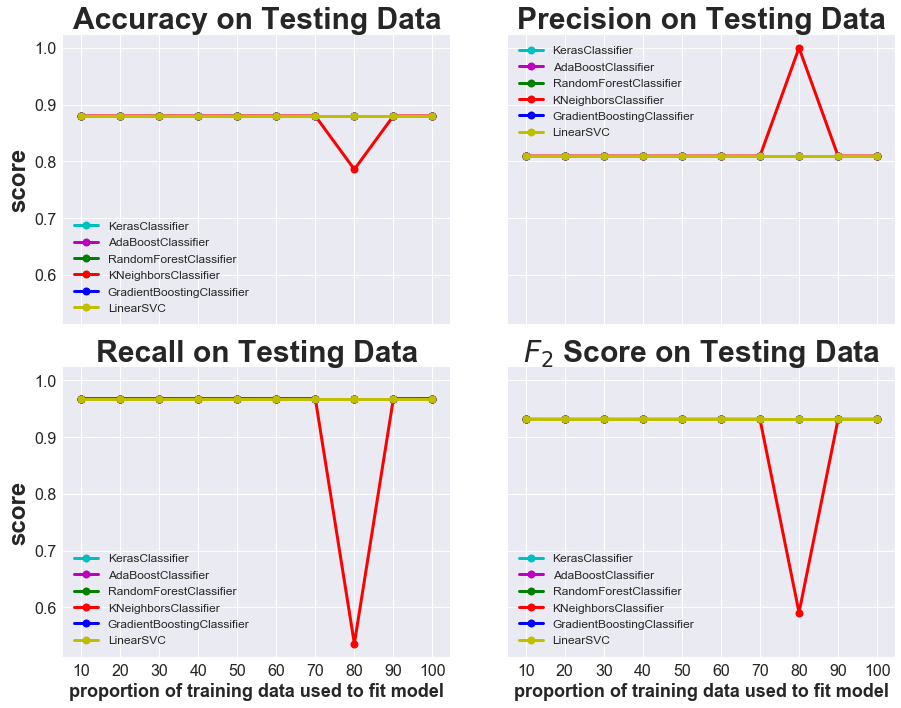

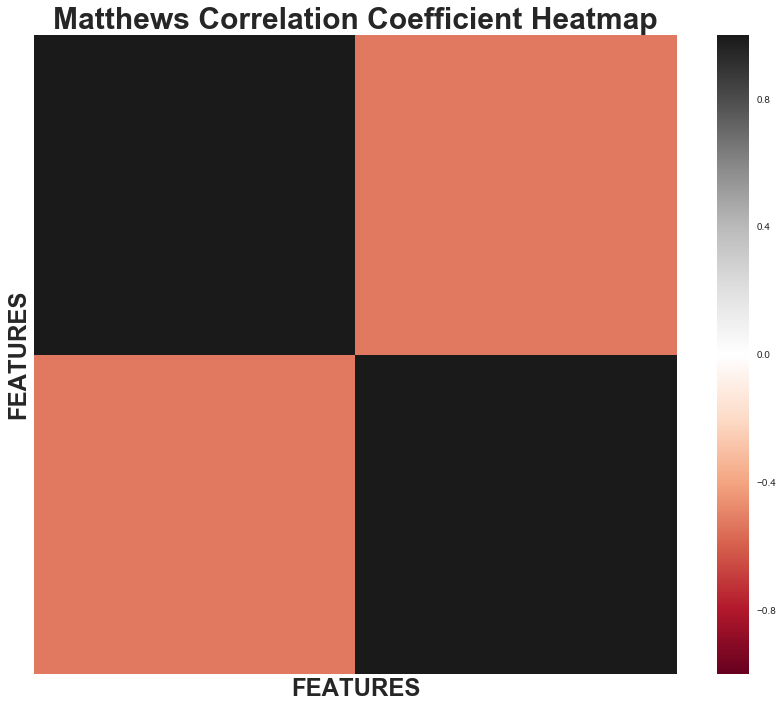

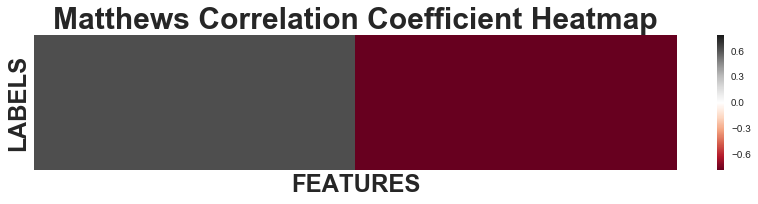

['odor_f', 'odor_n']

In [27]:
ed_2, Xy_2 = clf_eval_pipe(clfs, Xy, n_subsamps=10, reduce_features=True, n_features=2)
display(list(Xy_2[0].columns.values))
# display(ed_2)

### 4.2. Parameter tuning

#### 4.2.1. Grid search pipeline

In [28]:
def grid_search(clfs_and_grids, Xy):
    """
    Perform a grid search using the classifiers and corresponding grids in the dictionary `clfs_and_grids`.
    """
    
    best_clfs = {}
    X_trn, X_tst, y_trn, y_tst = Xy
    
    for clf, grid in clfs_and_grids.items():
        clf_name = clf.__class__.__name__
        name_len = len(clf_name)
        print(clf_name)
        print(name_len*'*')
        
        grid_clf = GridSearchCV(clf, grid, cv=5, verbose=1)
        grid_clf.fit(X_trn, y_trn);
        best_clf = grid_clf.best_estimator_
        best_clfs[clf_name] = best_clf
        preds = best_clf.predict(X_tst)
        
        print('  -Accuracy Score:  {:7.5f}'.format(accuracy_score(y_tst, preds)))
        print('  -Precision Score: {:7.5f}'.format(precision_score(y_tst, preds)))
        print('  -Recall Score:    {:7.5f}'.format(recall_score(y_tst, preds)))
        print('  -F_2 Score:       {:7.5f}\n\n'.format(fbeta_score(y_tst, preds, beta=2)))
        
    return best_clfs

#### 4.2.2. Classifier parameter visualization

In [29]:
def print_grid_search_params(clfs):
    """
    Print the parameters of the best classifiers chosen during the multiple grid searches (to standard out).
    """
    
    for clf_name, clf in clfs.items():
        name_len = len(clf_name)
        print(clf_name, 'Parameters')
        print((name_len + 11)*'*')
        display(clf.get_params())
        print('\n')
        
    return None

#### 4.2.3. Grid search on selected classifiers

In [30]:
svc_grid = {'dual': [True, False],
            'tol': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
            'C': [1, 10, 100, 1000, 10000],
            'max_iter': [1000, 5000, 10000]}

knn_grid = {'n_neighbors': [1, 2, 5, 10],
            'weights': ['uniform', 'distance'],
            'leaf_size': [1, 2, 4, 8, 15, 30],
            'metric': ['jaccard', 'minkowski']}

rfc_grid = {'n_estimators': [2, 4, 8, 10, 20, 30, 40],
            'criterion': ['gini', 'entropy'],
            'max_features': [None, 'auto'], 
            'min_samples_split': [2, 4, 6], 
            'min_samples_leaf': [1, 2, 4, 10],
            'max_leaf_nodes': [25, 50, 100, None]}

gbc_grid = {'learning_rate': [0.1, 0.25, 0.5],
            'n_estimators': [10, 25, 50, 100, 150],
            'max_depth': [2, 3, 5, 8],
            'min_samples_split': [2, 3, 4],
            'min_samples_leaf': [1, 2, 4]}

clfs_and_grids = {clf_1: svc_grid, clf_2: knn_grid, clf_6: rfc_grid, clf_7: gbc_grid}
# clfs_and_grids = {clf_4: rfc_grid}

In [31]:
best_clfs = grid_search(clfs_and_grids, Xy_7)
print_grid_search_params(best_clfs)

GradientBoostingClassifier
**************************
Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=1)]: Done 2700 out of 2700 | elapsed:  7.5min finished


  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


LinearSVC
*********
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:  1.9min finished


  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


KNeighborsClassifier
********************
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  3.8min finished


  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


RandomForestClassifier
**********************
Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
  -Accuracy Score:  0.97662
  -Precision Score: 0.97340
  -Recall Score:    0.97600
  -F_2 Score:       0.97548


KNeighborsClassifier Parameters
*******************************


[Parallel(n_jobs=1)]: Done 6720 out of 6720 | elapsed:  6.4min finished


{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'jaccard',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}



GradientBoostingClassifier Parameters
*************************************


{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'presort': 'auto',
 'random_state': 1984,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}



RandomForestClassifier Parameters
*********************************


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 25,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 1984,
 'verbose': 0,
 'warm_start': False}



LinearSVC Parameters
********************


{'C': 1,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 1984,
 'tol': 0.001,
 'verbose': 0}

---

## 5. Validation

### 5.1. Benchmark comparison

#### 5.1.1. Compute benchmark metrics

In [32]:
def get_benchmarks(X, y, level=4):
    """
    Get the benchmark evaluation scores. There are 4 levels, increasing in accuracy from 1 to 4.
    The default level is 4, so a user need not supply a level to get the best accuracy results.
     -Level 1 uses 1 feature.
     -Level 2 uses 2 features.
     -Level 3 uses 4 features.
     -Level 4 uses 6 features.
    """
    
    preds_1 = (X['odor_a'] != 1) & (X['odor_l'] != 1) & (X['odor_n'] != 1)
    
    preds_2 = ((X['odor_a'] != 1) & (X['odor_l'] != 1) & (X['odor_n'] != 1)) | \
              (X['spore-print-color_r'] == 1)
        
    preds_3 = ((X['odor_a'] != 1) & (X['odor_l'] != 1) & (X['odor_n'] != 1)) | \
              (X['spore-print-color_r'] == 1) | \
              ((X['odor_n'] == 1) & (X['stalk-surface-below-ring_y'] == 1) & (X['stalk-color-above-ring_n'] != 1))
            
    preds_4 = ((X['odor_a'] != 1) & (X['odor_l'] != 1) & (X['odor_n'] != 1)) | \
              (X['spore-print-color_r'] == 1) | \
              ((X['odor_n'] == 1) & (X['stalk-surface-below-ring_y'] == 1) & (X['stalk-color-above-ring_n'] != 1)) | \
              ((X['habitat_l'] == 1) & (X['cap-color_w'] == 1))
                
    if level == 1:
        preds = preds_1
        print('Benchmark Level 1')
    elif level == 2:
        preds = preds_2
        print('Benchmark Level 2')
    elif level == 3:
        preds = preds_3
        print('Benchmark Level 3')
    else:
        preds = preds_4
        print('Benchmark Level 4')
        
    print('*****************')
        
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f_2 = fbeta_score(y, preds, beta=2)
    
    print('  -Accuracy Score:  {:7.5f}'.format(accuracy))
    print('  -Precision Score: {:7.5f}'.format(precision))
    print('  -Recall Score:    {:7.5f}'.format(recall))
    print('  -F_2 Score:       {:7.5f}\n\n'.format(f_2))
          
    return [accuracy, precision, recall, f_2]

In [33]:
benchmark_eval_data = {}
for k in range(1, 5):
    benchmark_eval_data[k] = get_benchmarks(X_test, y_test, level=k)
# display(benchmark_eval_data)

Benchmark Level 1
*****************
  -Accuracy Score:  0.98523
  -Precision Score: 1.00000
  -Recall Score:    0.96800
  -F_2 Score:       0.97424


Benchmark Level 2
*****************
  -Accuracy Score:  0.99385
  -Precision Score: 1.00000
  -Recall Score:    0.98667
  -F_2 Score:       0.98930


Benchmark Level 3
*****************
  -Accuracy Score:  0.99877
  -Precision Score: 1.00000
  -Recall Score:    0.99733
  -F_2 Score:       0.99787


Benchmark Level 4
*****************
  -Accuracy Score:  1.00000
  -Precision Score: 1.00000
  -Recall Score:    1.00000
  -F_2 Score:       1.00000




#### 5.1.2. Models-to-benchmark comparison visualization

In [34]:
def graph_ed_bm(eval_data, benchmark, clf_names, n_feats):
    """
    Produce a bar chart comaring the benchmark scores to the evaluation 
    data from the best classifiers over a range of reduced feature sizes.
    
    Thanks to `pythonspot.com` for some assistance configuring these bar charts:
    https://pythonspot.com/matplotlib-bar-chart.
    """
    
    metrics = ['Accuracy', 'Precision', 'Recall', '$F_2$']
    metrics_short = ['acc', 'pre', 'rec', 'f2']
    groups = len(eval_data)
    n_clfs = len(clf_names)
    y_locs = np.arange(groups)
    bar_height = 0.8/n_clfs  
    bm_ls = [':', '-.', '--', '-']
    bm_labels = ['BM L1: 1 Feature', 'BM L2: 2 Features', 'BM L3: 4 Features', 'BM L4: 6 Features']
    
    # k=0 -> Accuracy, k=1 -> Precision, k=2 -> Recall, k=3 -> F_2
    for k in range(4):
        
        fig, ax = plt.subplots(figsize=(15, 6))
        
        # Build the vertical line locations for the benchmark values
        bm = []
        for j in range(4):
            bm.append(benchmark[j+1][k])
        
        # Build the data for the k-th bar chart
        metric_data = []
        for clf_name in clf_names:
            clf_metric_data = []
            for ed in eval_data:
                clf_metric_data.append(ed[clf_name][k][-1])
            metric_data.append(clf_metric_data)
        
        # Plot the horizontal bar charts
        for i in range(n_clfs):
            plt.barh((y_locs + i*bar_height), metric_data[i], bar_height, label=clf_names[i])
            
        # Plot the benchmark vertical lines
        for h in range(4):
            plt.axvline(bm[h], linestyle=bm_ls[h], linewidth=3, color='k', label=bm_labels[h])
            
        # zoomed-in plots
        plt.xlim(0.8, 1.1)
        
        # zoomed-out plots (better comparison perspective)
        # plt.xlim(0, 1.5)
        
        plt.xticks(fontsize=20)
        plt.yticks((y_locs + (n_clfs - 1)*(bar_height/2)), n_feats, fontsize=20, fontweight='heavy')
        plt.title('{} Scores Compared to Benchmarks'.format(metrics[k]), fontsize=30, fontweight='heavy')
        plt.legend(loc='best', fontsize=16)
        plt.savefig('images/clf_2_bm_{}.pdf'.format(metrics_short[k]))
        plt.show()

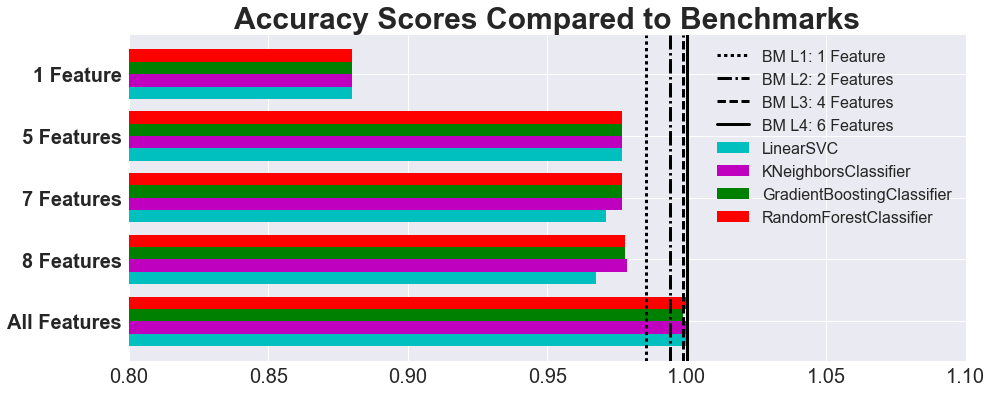

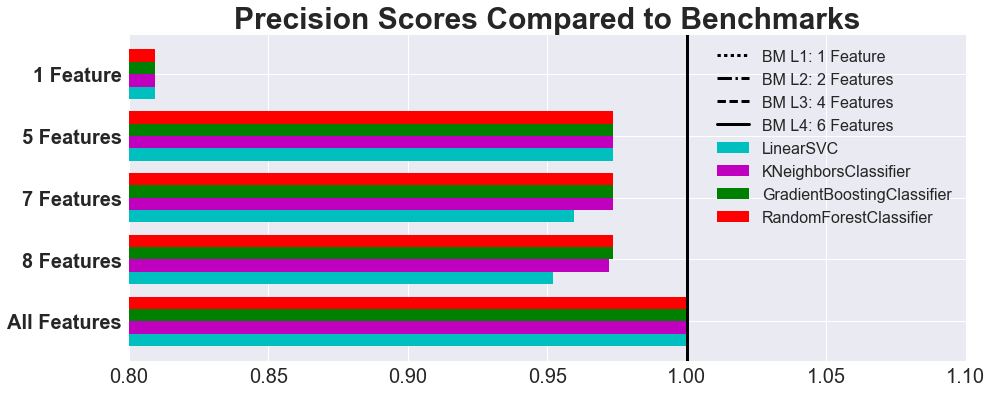

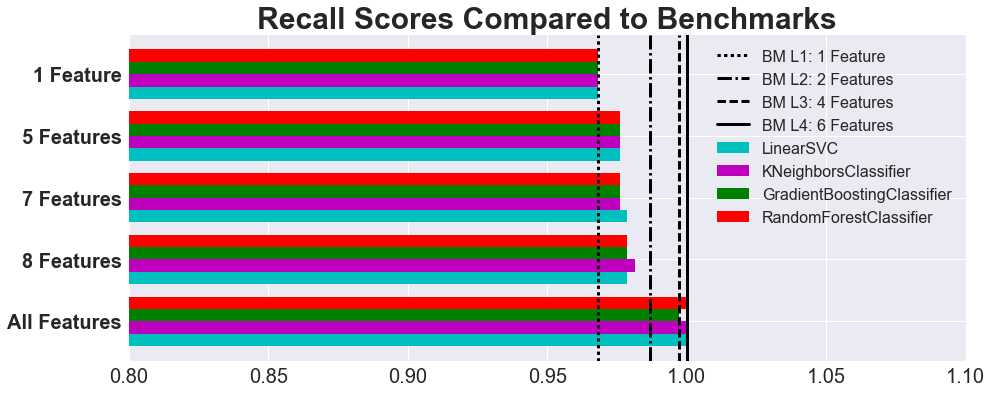

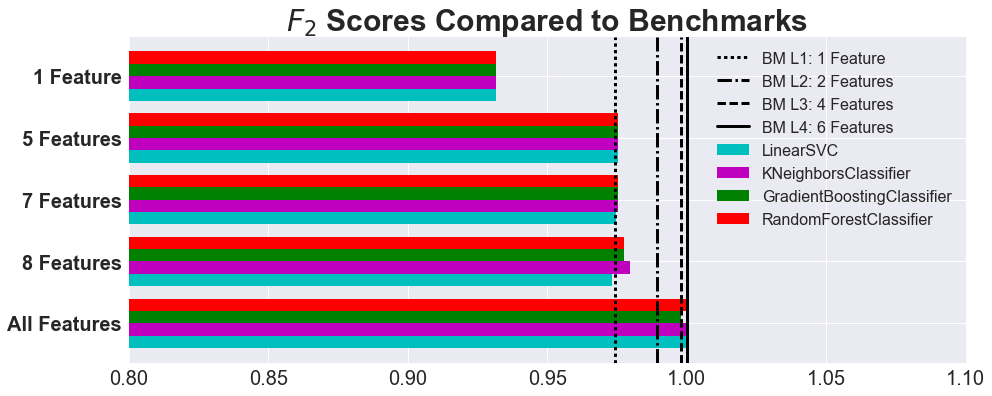

In [35]:
eval_data = [ed, ed_15, ed_10, ed_7, ed_2]
n_feats = ['All Features', '8 Features', '7 Features', '5 Features', '1 Feature']
clf_names = ['LinearSVC', 'KNeighborsClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']
graph_ed_bm(eval_data, benchmark_eval_data, clf_names, n_feats)

### 5.2. Sensitivity analysis

#### 5.2.1. Sensitivity pipeline

In [36]:
def analyze_sensitivity(clfs, seeds, reduced_features=False, cols=None):
    """
    Perform a sensitivity analysis on the selected models by varying the training/testing data split.
    """
    
    if reduced_features:
        features_sa = features[cols]
    else:
        features_sa = features
        
    acc_sa = {}
    pre_sa = {}
    rec_sa = {}
    f_2_sa = {}
    
    for clf in clfs:
        clf_name = clf.__class__.__name__
        acc_sa[clf_name] = []
        pre_sa[clf_name] = []
        rec_sa[clf_name] = []
        f_2_sa[clf_name] = []
        
    for seed in seeds:
        Xy_sa = train_test_split(features_sa, label, test_size=0.2, random_state=seed)
        seed_ed = clf_eval_pipe(clfs, Xy_sa, n_subsamps=1, print_data=False, graph_data=False)
        for clf in clfs:
            clf_name = clf.__class__.__name__
            acc_sa[clf_name].append(seed_ed[clf_name][0][0])
            pre_sa[clf_name].append(seed_ed[clf_name][1][0])
            rec_sa[clf_name].append(seed_ed[clf_name][2][0])
            f_2_sa[clf_name].append(seed_ed[clf_name][3][0])
            
    return acc_sa, pre_sa, rec_sa, f_2_sa

#### 5.2.2. Sensitivity visualization

In [41]:
def graph_sensitivity(sa_data, seeds):
    """
    Produce a line graph of the sensitivity analysis results
    """
    
    # Format x-ticks
    xtick_locs = range(len(seeds))
    xtick_labs = []
    for seed in seeds:
        xtick_labs.append(str(seed))
        
    # Cycle through linestyles
    ls = ['-', '--', '-.', ':']
    
    # Set plot style and create subplot object
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(2, 2, figsize=(13, 10), sharex=True, sharey=True)
    
    # Plot the `accuracy` data
    lc = 0
    for clf_name, data in sa_data[0].items():
        axes[0, 0].plot(xtick_locs, data, 'o', label=clf_name, markersize=8, linewidth=3, linestyle=ls[lc%4])
        lc += 1
    axes[0, 0].legend(fontsize=14, loc='best')
    axes[0, 0].set_title('Accuracy', fontsize=30, fontweight='heavy')
    axes[0, 0].set_ylabel('score', fontsize=24, fontweight='heavy')
    axes[0, 0].tick_params(labelsize=14)
    
    # Plot the `precision` data
    lc = 0
    for clf_name, data in sa_data[1].items():
        axes[0, 1].plot(xtick_locs, data, 'o', label=clf_name, markersize=8, linewidth=3, linestyle=ls[lc%4])
        lc += 1
    axes[0, 1].legend(fontsize=14, loc='best')
    axes[0, 1].set_title('Precision', fontsize=30, fontweight='heavy')

    # Plot the `recall` data
    lc = 0
    for clf_name, data in sa_data[2].items():
        axes[1, 0].plot(xtick_locs, data, 'o', label=clf_name, markersize=8, linewidth=3, linestyle=ls[lc%4])
        lc += 1
    axes[1, 0].legend(fontsize=14, loc='best')
    axes[1, 0].set_title('Recall', fontsize=30, fontweight='heavy')
    axes[1, 0].set_xlabel('random seed value', fontsize=24, fontweight='heavy')
    axes[1, 0].set_ylabel('score', fontsize=24, fontweight='heavy')
    axes[1, 0].tick_params(labelsize=14)

    # Plot the `F_2` data
    lc = 0
    for clf_name, data in sa_data[3].items():
        axes[1, 1].plot(xtick_locs, data, 'o', label=clf_name, markersize=8, linewidth=3, linestyle=ls[lc%4])
        lc += 1
    axes[1, 1].legend(fontsize=14, loc='best')
    axes[1, 1].set_title('$F_2$ Score', fontsize=30, fontweight='heavy')
    axes[1, 1].set_xlabel('random seed value', fontsize=24, fontweight='heavy')
    axes[1, 1].tick_params(labelsize=14)
    
    plt.ylim(0, 1)
    plt.xticks(xtick_locs, xtick_labs, fontsize=14)
    plt.tight_layout()
    plt.savefig('images/sensitivity.pdf')
    plt.show()
    
    return None

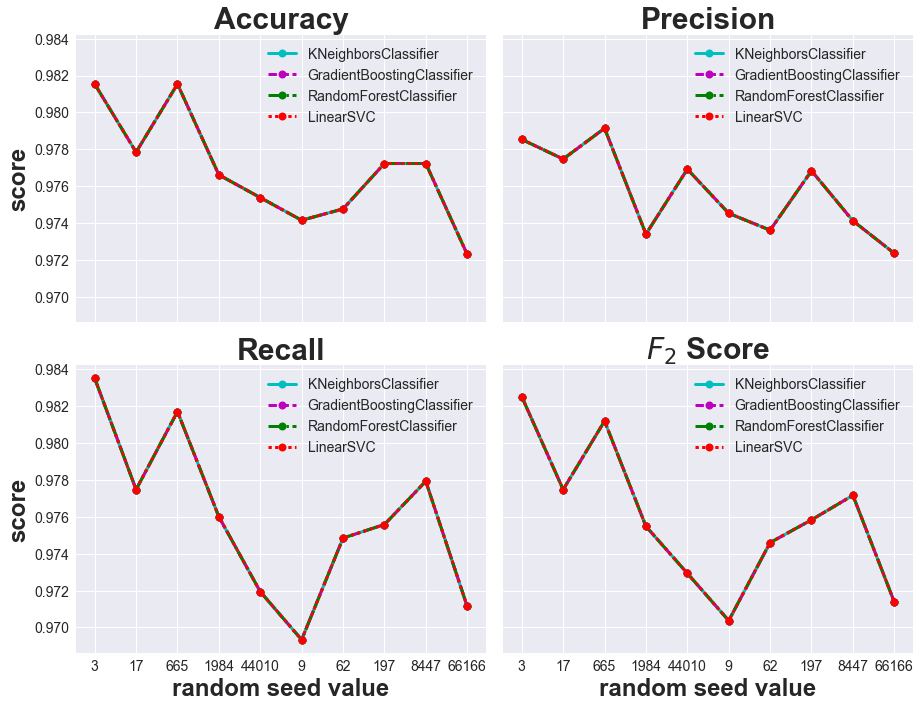

In [40]:
clfs_sa = [clf_1, clf_2, clf_6, clf_7]
seeds_sa = [3, 17, 665, 1984, 44010, 9, 62, 197, 8447, 66166]
cols_sa = list(Xy_7[0].columns.values)
sa_data = analyze_sensitivity(clfs_sa, seeds_sa, reduced_features=True, cols=cols_sa)

graph_sensitivity(sa_data, seeds_sa)

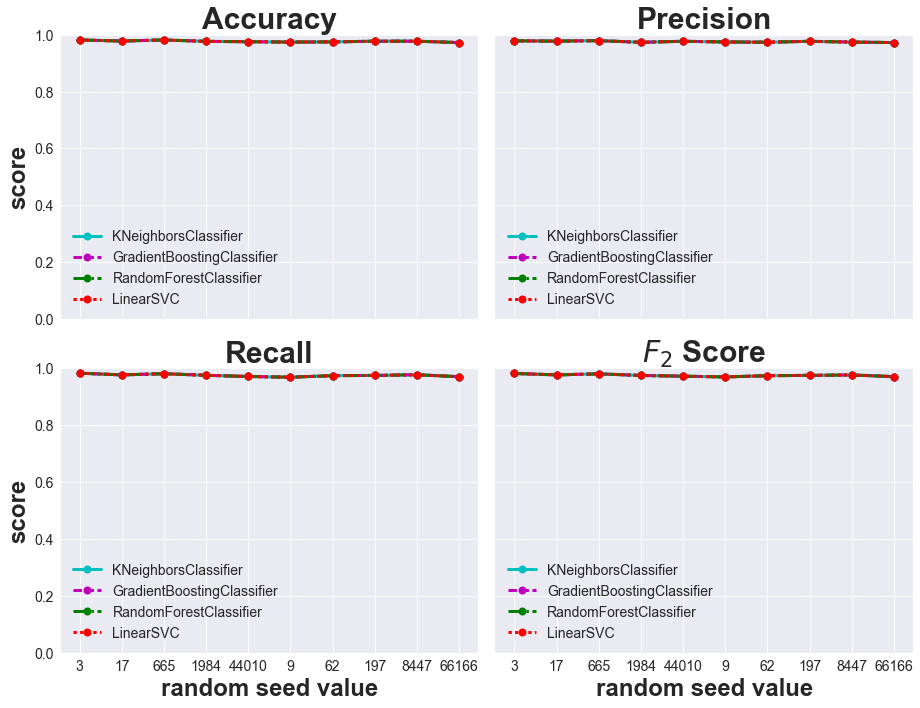

In [42]:
graph_sensitivity(sa_data, seeds_sa)